# Centered Snowfall

In [1]:
import xarray as xr 
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cartopy.feature as cfeature
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import colorsys
#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects

#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'
colors = ['#F6A5AE', '#228833', '#4577AA','#67CCED', '#AA3377']
from scipy.ndimage import gaussian_filter

from metpy.interpolate import cross_section
import metpy.calc as mpcalc
from scipy import stats
from metpy.calc import lat_lon_grid_deltas, first_derivative

from matplotlib.patches import Rectangle
import matplotlib.ticker as mticker
from cartopy.util import add_cyclic_point

In [2]:
colors = ['#F6A5AE', '#228833', '#4577AA','#67CCED', '#AA3377']


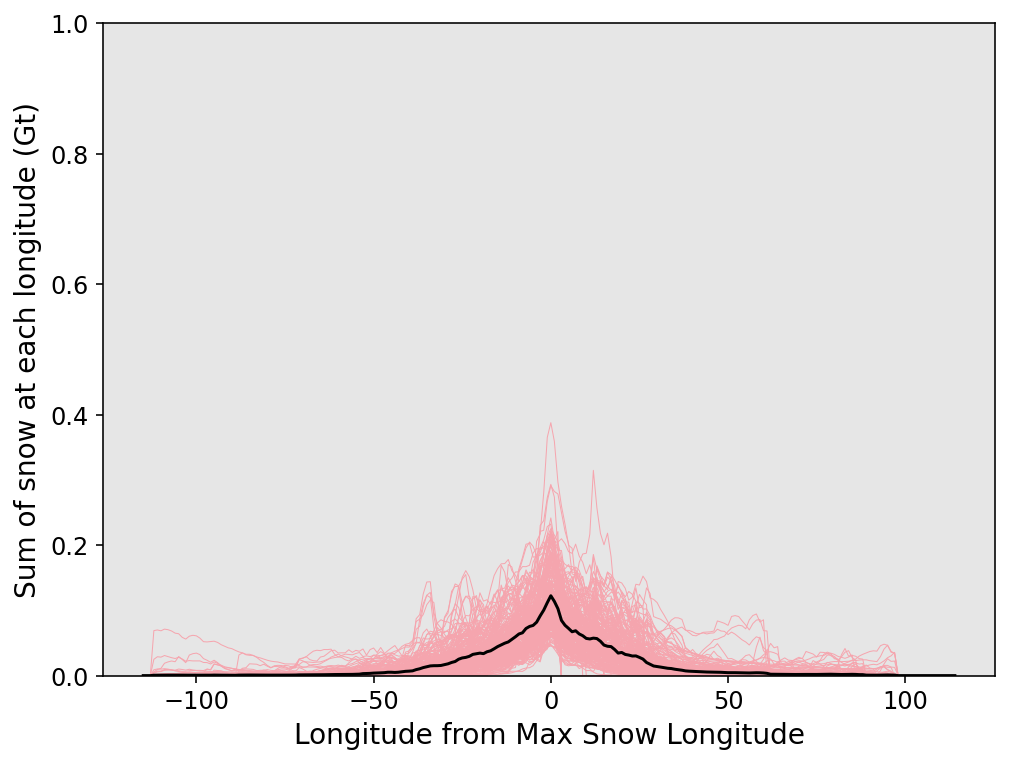

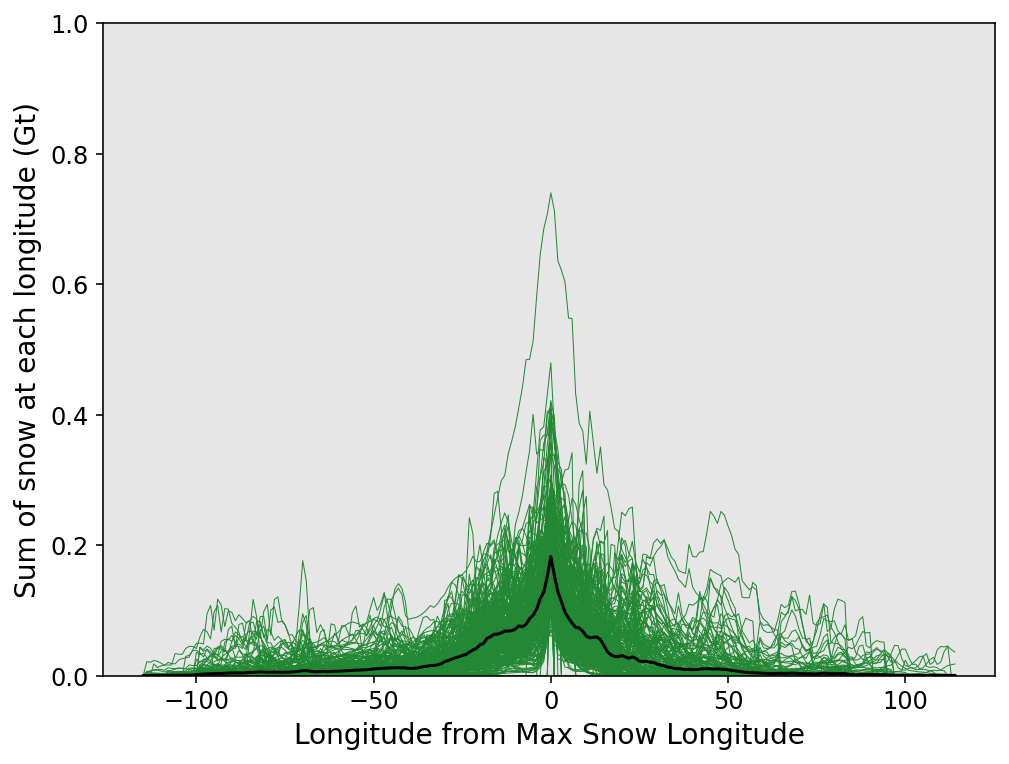

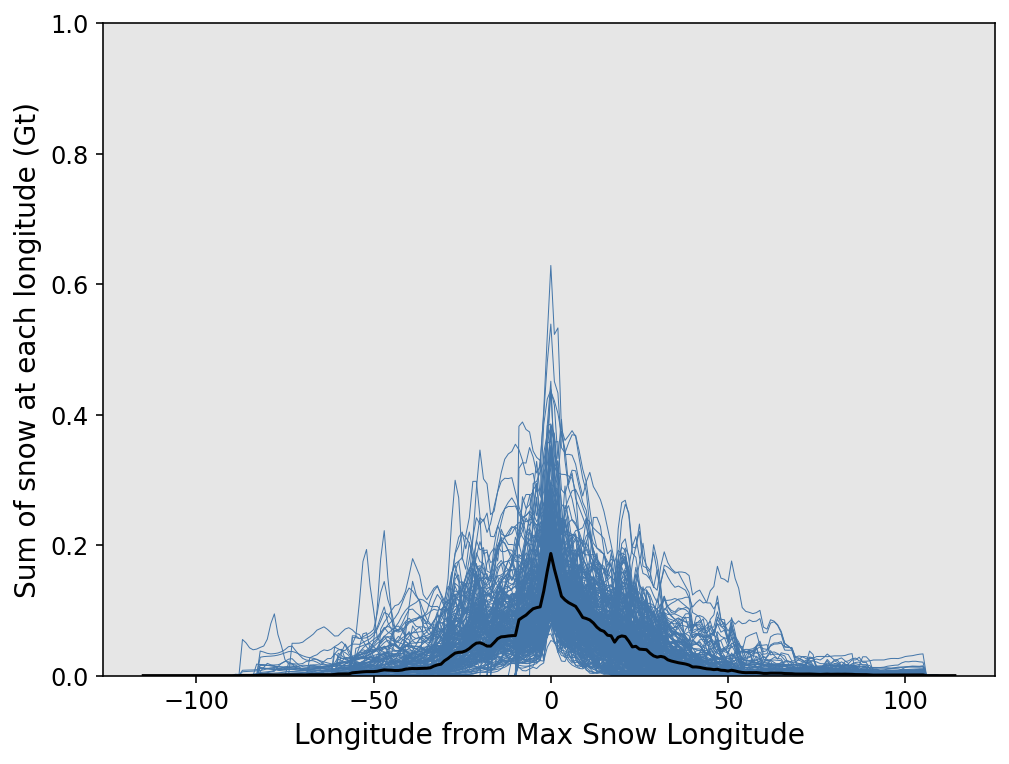

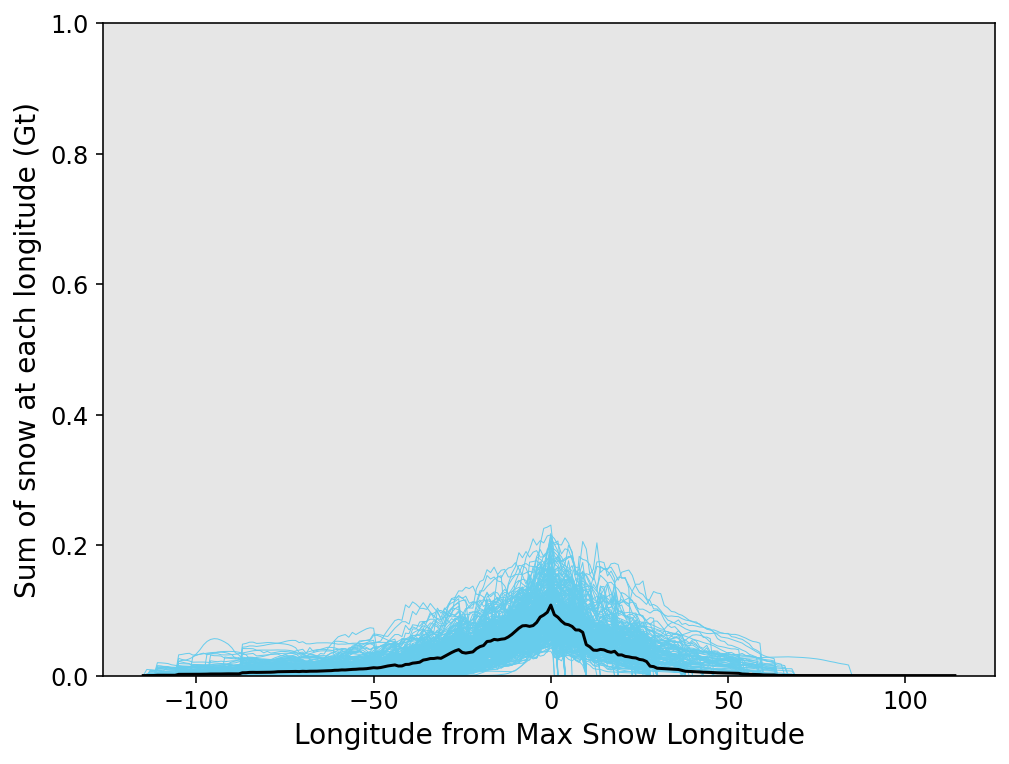

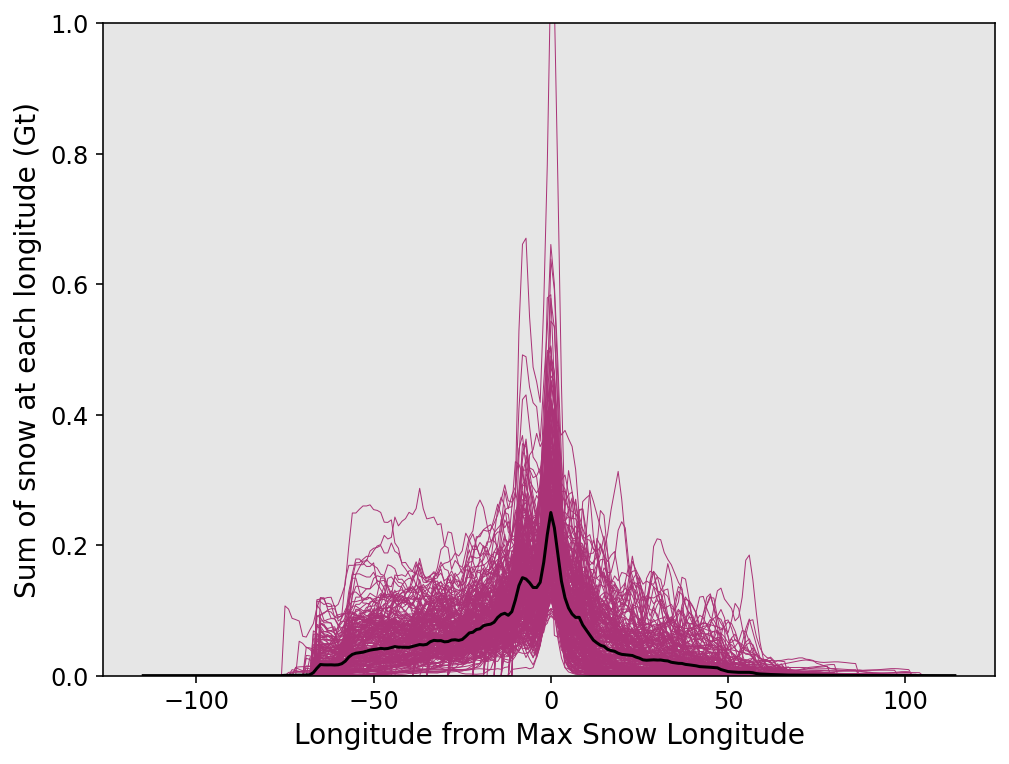

In [4]:
Means_all_regions = []
lower_bound = []
upper_bound = []
for r in range(5):
    precip_weights = np.array(pd.read_csv('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/Precip/TP_precip_weights_region'+str(r)+'.csv', index_col = 0))
    if r == 3:
        precip_weights = precip_weights[:, :115]
    len_shifted_weights = 2*int(np.shape(precip_weights)[1])
    num_times = int(np.shape(precip_weights)[0])
    shifted_weights = np.zeros((num_times,len_shifted_weights))

    for t in range(num_times):
        max_id = int(np.where(precip_weights[t] == precip_weights[t].max())[0])
        shifted_weights[t][(115-max_id):(230-max_id)] = precip_weights[t]

    fig, ax=plt.subplots(ncols=1, nrows=1, figsize=(8, 6))
    for t in range(num_times):
        ax.plot(np.arange(-115,115,1), shifted_weights[t], color = colors[r], linewidth = .5)
        ax.set_ylim(0,1)
        ax.set_xlabel('Longitude from Max Snow Longitude')
        ax.set_ylabel('Sum of snow at each longitude (Gt)')

    ax.plot(np.arange(-115,115,1), np.mean(shifted_weights,0), color = 'black', linewidth = 1.5)
    Means_all_regions.append(np.array(np.mean(shifted_weights,0)))
    upper_bound.append(np.percentile(shifted_weights, 95, 0))
    lower_bound.append(np.percentile(shifted_weights, 5, 0))

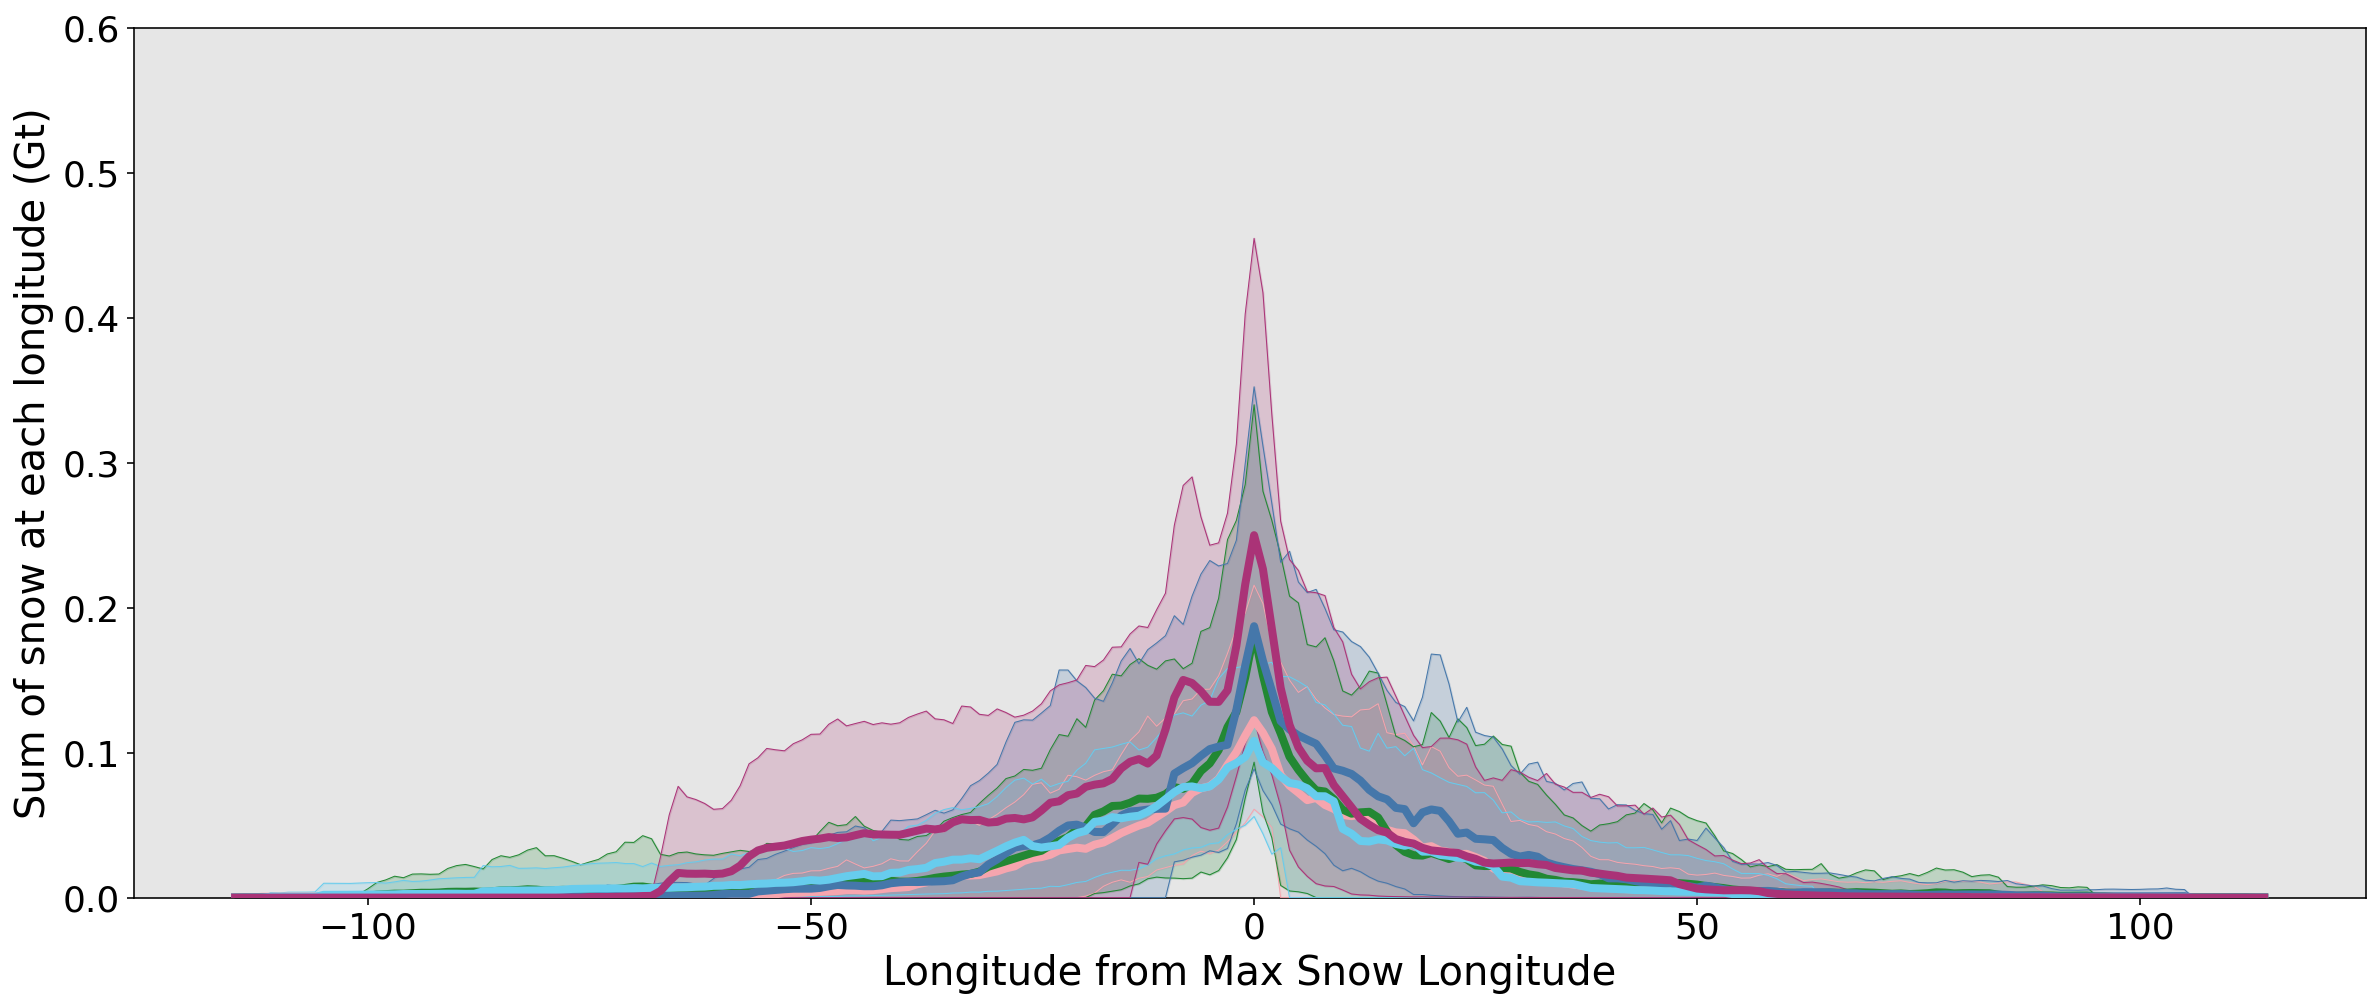

In [5]:
cutoffs = [1.9, 2.6, 2.8, 1.4, 4.4]
fig, ax=plt.subplots(ncols=1, nrows=1, figsize=(20, 8))
for r in range(5):
    ax.plot(np.arange(-115,115,1), Means_all_regions[r], color = colors[r], linewidth = 4, label = 'Region '+str(r+1)+',  '+str(cutoffs[r])+'Gt', zorder = 10)
    ax.plot(np.arange(-115,115,1), lower_bound[r], color = colors[r], linewidth = .5, zorder = 9)
    ax.plot(np.arange(-115,115,1), upper_bound[r], color = colors[r], linewidth = .5, zorder = 9)

    ax.set_ylim(0,.6)
    ax.set_xlabel('Longitude from Max Snow Longitude', size = 20)
    ax.set_ylabel('Sum of snow at each longitude (Gt)', size = 20)
    ax.fill_between(np.arange(-115,115,1), lower_bound[r], upper_bound[r], color = colors[r], alpha = .2)
    ax.tick_params(axis='both', labelsize=18)
# ax.legend(fontsize=20, title='                   85th% Snow Threshold', title_fontsize = 20)

plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/centered_snowfall.png', dpi = 300, transparent = True, bbox_inches = 'tight')


## Make Snow Heatmap

### Make and save data 

In [6]:
for y in np.arange(1980,2020):
    precip = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/Maclennan/MERRA2/PRECSN_hourly_'+str(y)+'.nc', chunks = 'auto').sel(lat = slice(-90,-40))
    precip = (precip*60*60/(10**12)).sum(dim = 'time').load()
    precip.to_netcdf('/scratch/alpine/reba1583/yrly_snow/'+str(y))
    print(y)

1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


### Plot Data

In [13]:
yrly_precsn = []
years = np.arange(1980,2020)
for y in np.arange(1980,2020):
    yrly_precsn.append(xr.open_mfdataset('/scratch/alpine/reba1583/yrly_snow/'+str(y)).expand_dims(dim={"time": [int(y)]}).load())
yearly_data = xr.concat(yrly_precsn, dim = 'time') ### Gt over a year

In [26]:
basin_mask = xr.open_mfdataset('/projects/reba1583/Research/Data/AIS_Full_basins_Zwally_MERRA2grid.nc').sel(lat = slice(-90,-40)).Zwallybasins.load()
basin_mask = (basin_mask> 0).values

/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


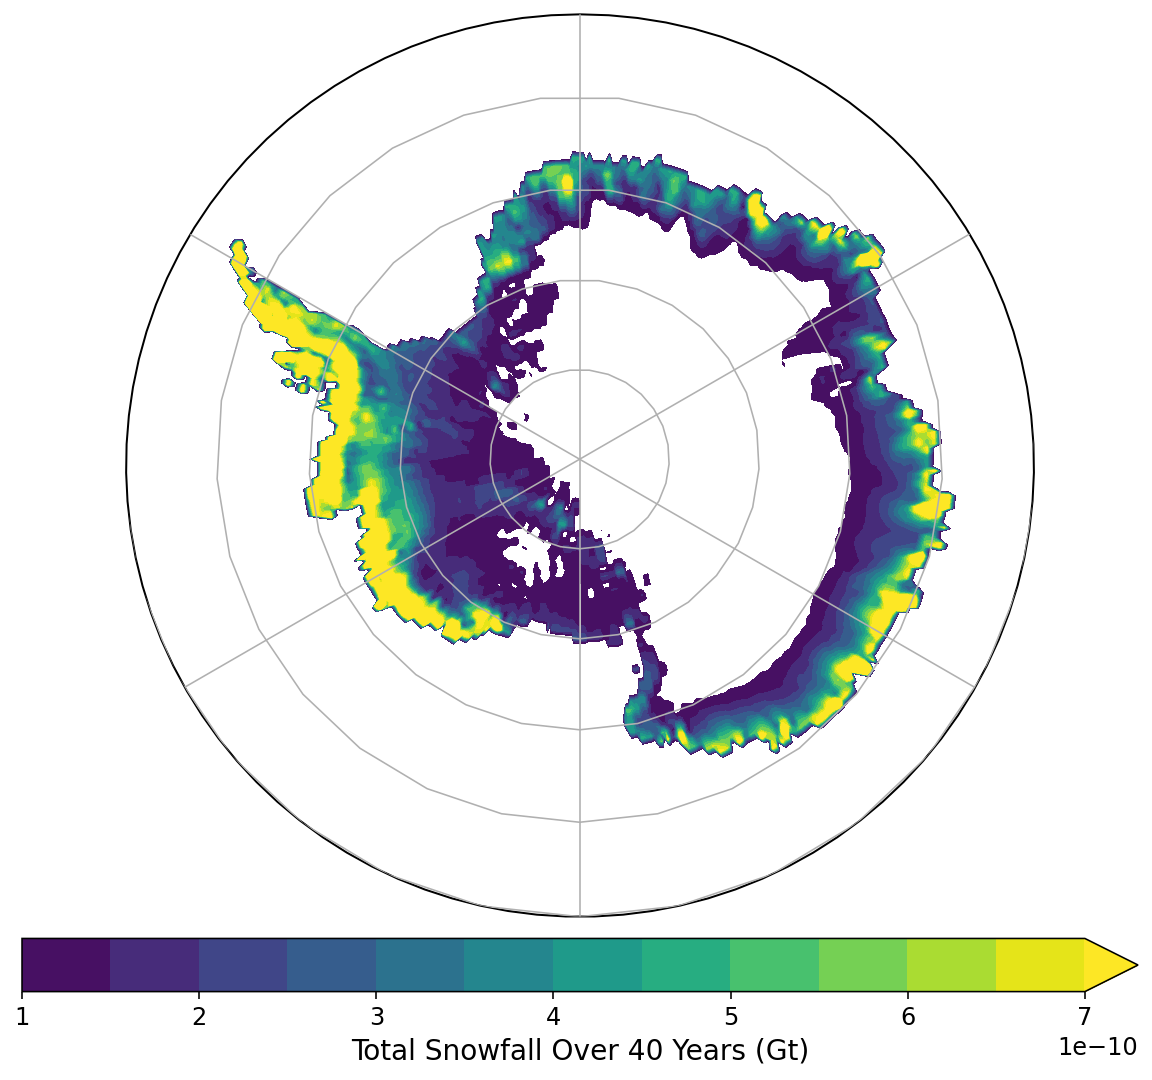

In [41]:
fig, ax=plt.subplots(ncols=1,nrows=1,figsize=(10,10),subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
grid=ax.gridlines(zorder = 20)
grid.n_steps=30
levels = np.arange(1e-10, 7.5e-10, .5e-10)
cf = ax.contourf(yearly_data.lon, yearly_data.lat, (yearly_data.mean(dim = 'time').PRECSN*basin_mask), cmap = 'viridis', extend = 'max', levels = levels, transform=ccrs.PlateCarree())
fig.colorbar(cf, ax = ax, orientation = 'horizontal', label = 'Total Snowfall Over 40 Years (Gt)', pad = .02)


/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


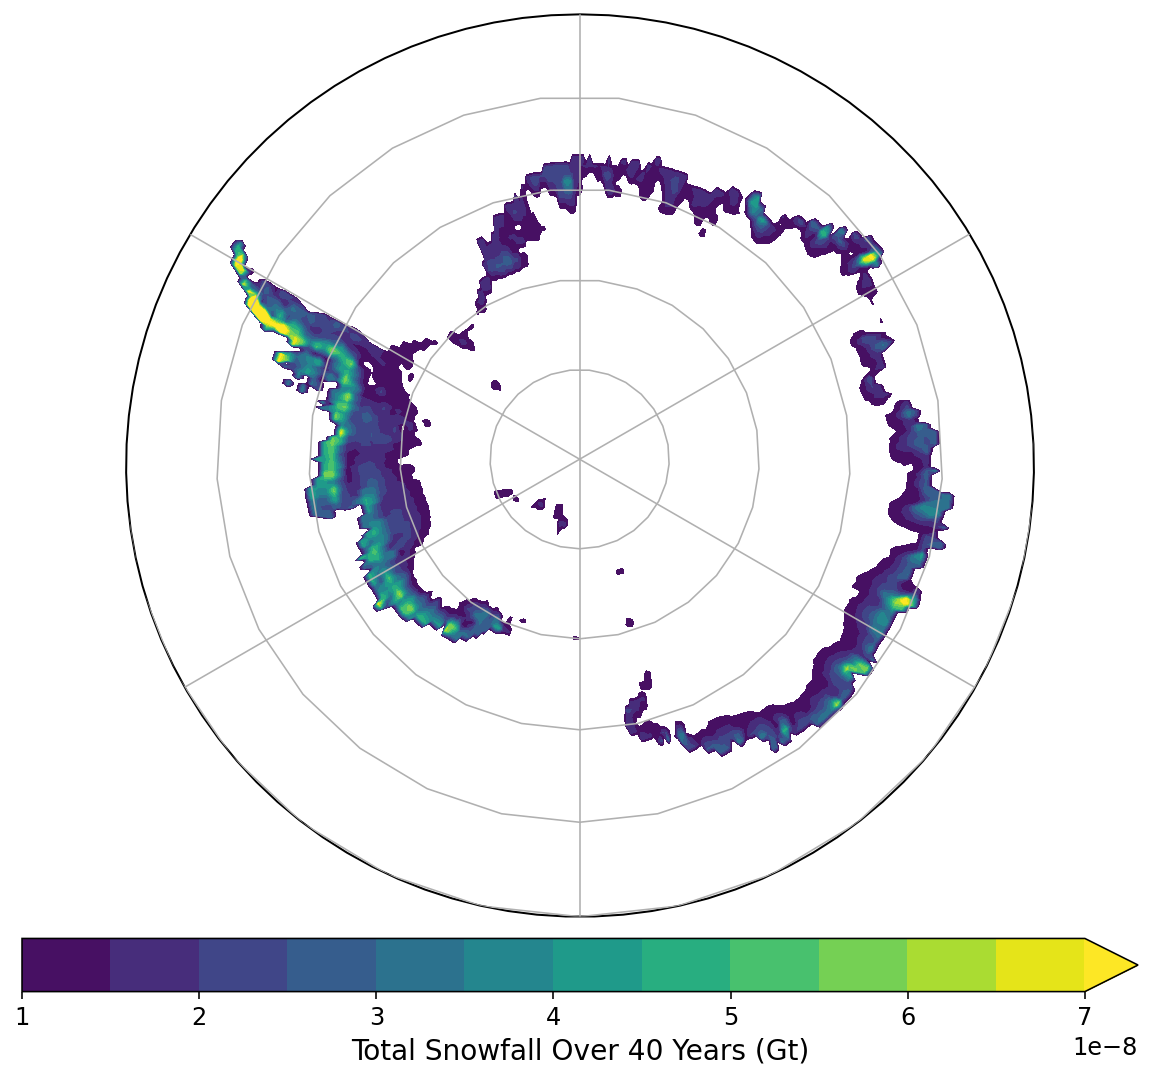

In [44]:
fig, ax=plt.subplots(ncols=1,nrows=1,figsize=(10,10),subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
grid=ax.gridlines(zorder = 20)
grid.n_steps=30
levels = np.arange(1e-8, 7.5e-8, .5e-8)
cf = ax.contourf(yearly_data.lon, yearly_data.lat, (yearly_data.sum(dim = 'time').PRECSN*basin_mask), cmap = 'viridis', extend = 'max', levels = levels, transform=ccrs.PlateCarree())
fig.colorbar(cf, ax = ax, orientation = 'horizontal', label = 'Total Snowfall Over 40 Years (Gt)', pad = .02)


## Make histogram of top precip centers for each region

In [3]:
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',edgecolor='none',facecolor='none') # 10m, 50m, 110m
ice_shelf_line = cfeature.NaturalEarthFeature('physical', 'antarctic_ice_shelves_lines', '50m',edgecolor='black',facecolor='none') # 10m, 50m, 110m


In [4]:
regional_center_lons = []
for r in range(5):
    Center_lons = []
    basins = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/AIS_basins_Zwally_MERRA2grid.nc').sel(lat = slice(-90,-60)).load()
    slice_start = np.array([-36, 36, 108, -180 , -108])
    slice_end = np.array([36, 108, 180, -108.5, -36])
    lons = basins.sel(lon = slice(slice_start[r], slice_end[r])).lon.values

    precip_weights = np.array(pd.read_csv('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/Precip/TP_precip_weights_region'+str(r)+'.csv', index_col = 0))
    num_times = int(np.shape(precip_weights)[0])
    if r == 3:
        precip_weights = precip_weights[:, :115]

    for t in range(num_times):
        max_id = int(np.where(precip_weights[t] == precip_weights[t].max())[0])
        Center_lons.append(lons[max_id])
    regional_center_lons.append(np.array(Center_lons))

In [5]:
regional_num_lons = []
for r in range(5):
#     bins = np.arange(slice_start[r], slice_end[r]+6, 6)
    bins = np.arange(slice_start[r], slice_end[r]+12, 12)

    num_lons = []
    for n in range(len(bins)-1):
        bin_data = regional_center_lons[r][(regional_center_lons[r]>=bins[n]) & (regional_center_lons[r]<=bins[n+1])]
        num_lons.append(len(bin_data))
#     regional_num_lons.append(np.array(num_lons)*(20/120))
    regional_num_lons.append(np.array(num_lons)*(20/180))

Text(-72, -80, '5')

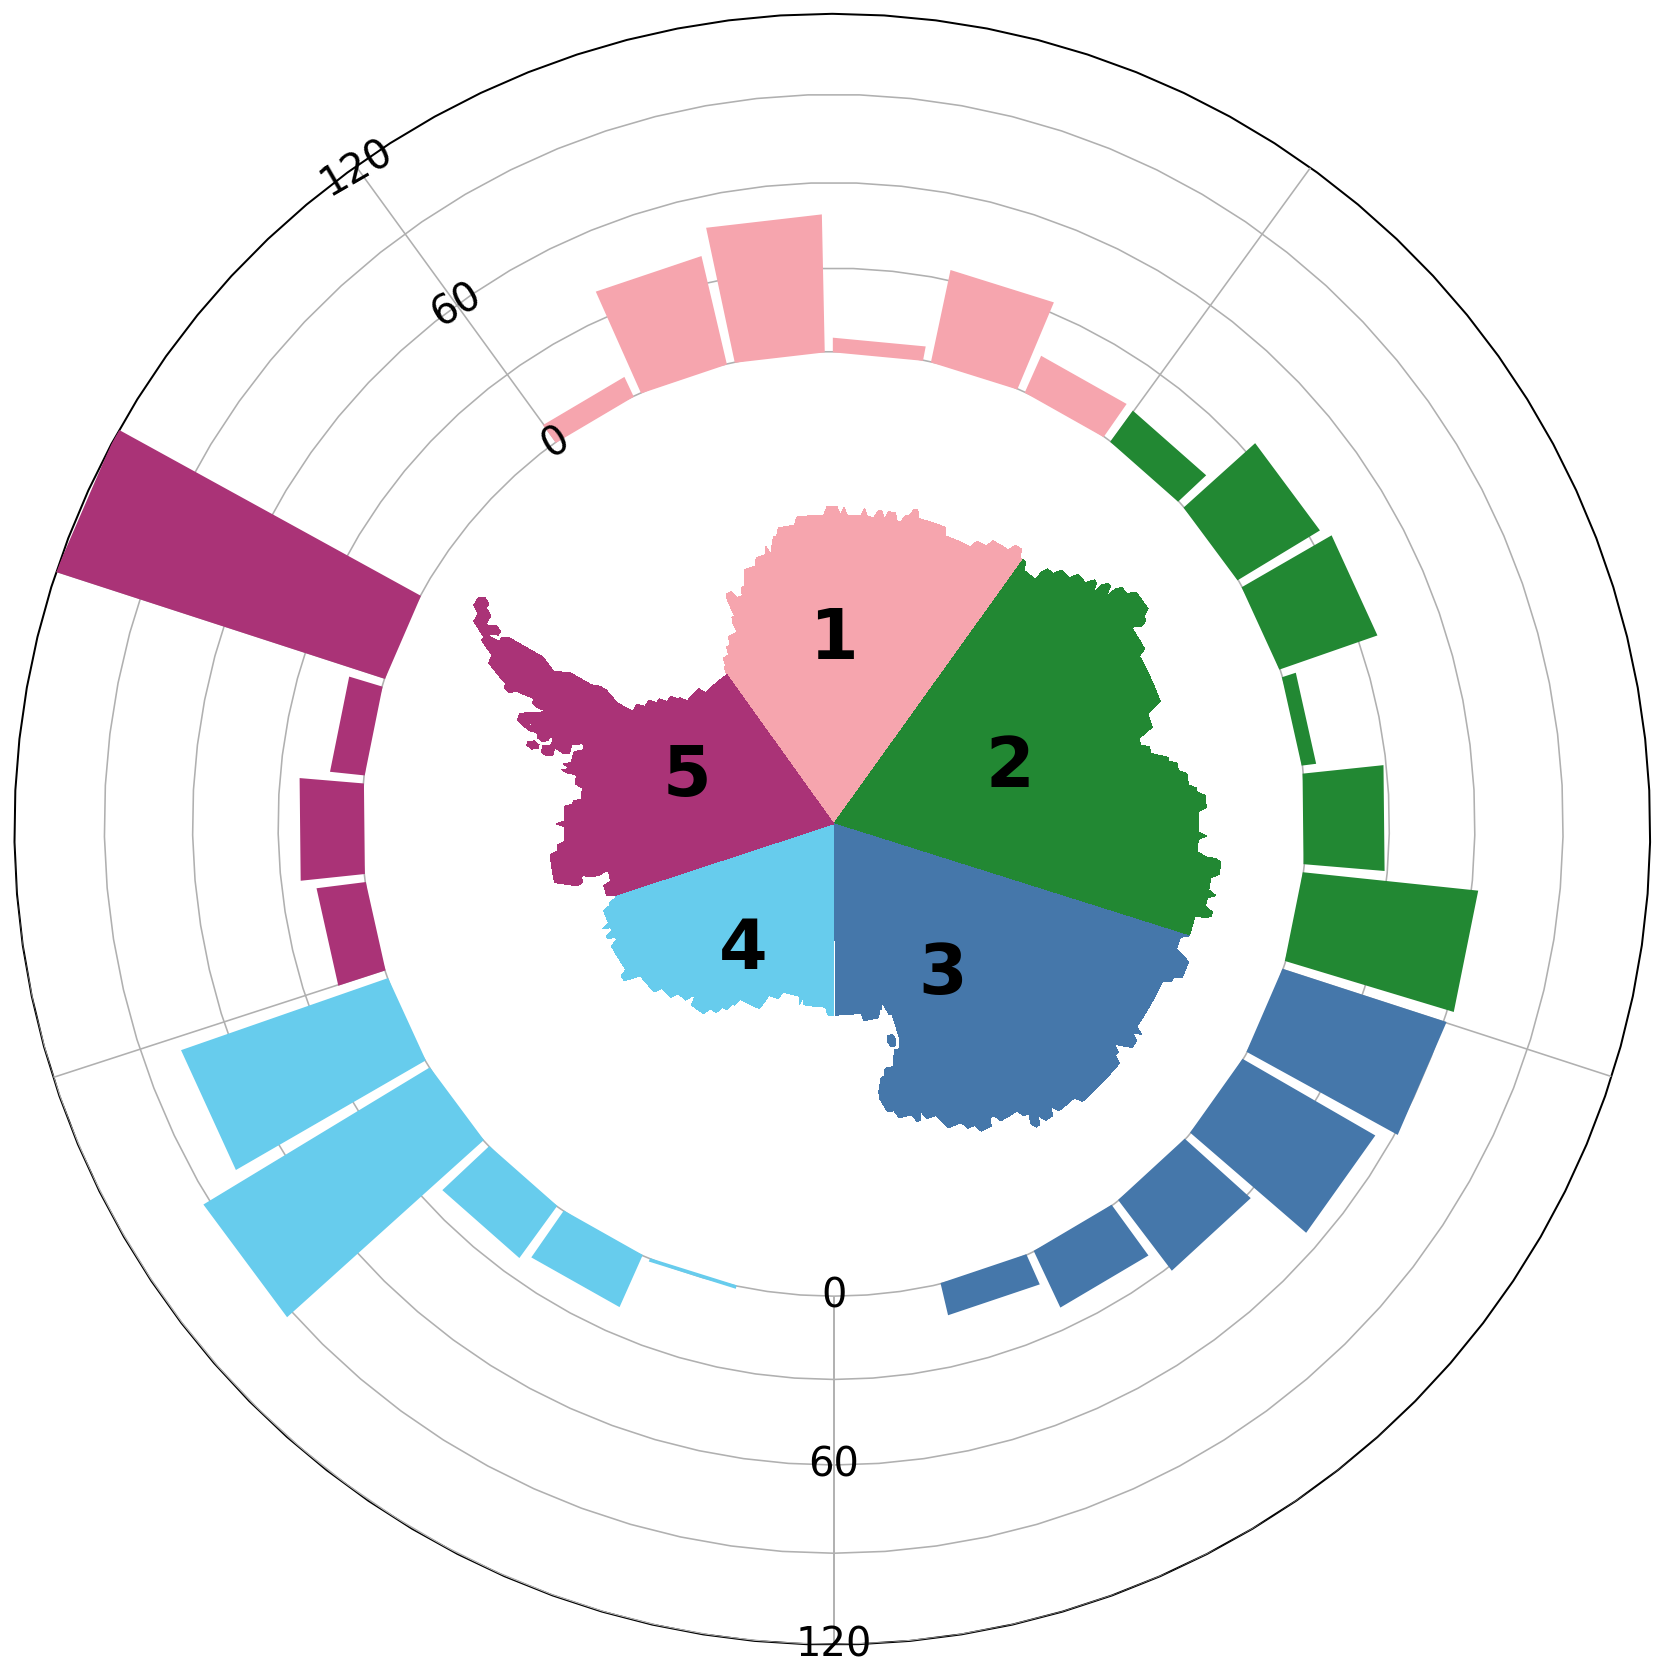

In [30]:
fig, ax=plt.subplots(ncols=1,nrows=1,figsize=(15,15),subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})
# plt.suptitle('Annual AR Frequency', size = 30)
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
grid=ax.gridlines(zorder = 20)
grid.n_steps=90
# grid.xlocator = mticker.FixedLocator([0,36, 72, 108, 144, 180, -180, -144, -108, -72, -36])
grid.xlocator = mticker.FixedLocator([36, 108,  180, -180,  -108, -72, -36, 36])
grid.ylocator = mticker.FixedLocator([ -60, -55, -50, -45, -40]) #-90, -85, -80, -75, -70, -65,
# ax.add_feature(ice_shelf_line, linewidth = 1,zorder = 11, color = 'black')
# ax.coastlines(resolution='50m', linewidth = 1,zorder = 11, color = 'black')

basins = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/AIS_basins_Zwally_MERRA2grid.nc').sel(lat = slice(-90,-60)).load()
basins = basins.Zwallybasins > 0
slice_start_extend = np.array([-36.5, 35.5, 107.5, -180.5 , -108.5])
slice_end_extend = np.array([36.5,1078.5, 180.5, -107.5 , -35.5])

for r in range(5):
    color = colors[r]
#     bins = np.arange(slice_start[r], slice_end[r]+6, 6)
    bins = np.arange(slice_start[r], slice_end[r]+12, 12)
    for b in range(len(regional_num_lons[r])):
        rect = Rectangle(xy=(bins[b], -60), width=(bins[1]- bins[0])*.9, height = regional_num_lons[r][b], transform=ccrs.PlateCarree(), linestyle='-', color = color, lw=.9,  alpha = 1, zorder =20) 
        ax.add_artist(rect)
   

    slice_data = basins.sel(lon  = slice(slice_start_extend[r], slice_end_extend[r]+.25))
    ax.contourf(slice_data.lon, slice_data.lat, xr.where(slice_data.values==True,1,0), levels = np.arange(-.5,1.5,.75),cmap = ListedColormap([ 'None', colors[r]]), transform=ccrs.PlateCarree())

ax.text(-36,-40.5, '120', fontsize = 20, rotation = 30, ha='center',va='center',transform = ccrs.PlateCarree(), zorder = 30)
ax.text(-36,-50, '60', fontsize = 20, rotation = 30, ha='center',va='center',transform = ccrs.PlateCarree(), zorder = 30)
ax.text(-36,-60, '0', fontsize = 20, rotation = 30,ha='center',va='center',transform = ccrs.PlateCarree(), zorder = 30)

ax.text(-180,-40, '120', fontsize = 20, rotation = 0, ha='center',va='center',transform = ccrs.PlateCarree(), zorder = 30)
ax.text(-180,-50, '60', fontsize = 20, rotation = 0, ha='center',va='center',transform = ccrs.PlateCarree(), zorder = 30)
ax.text(-180,-60, '0', fontsize = 20, rotation = 0,ha='center',va='center',transform = ccrs.PlateCarree(), zorder = 30)

ax.text(0,-78, '1', transform=ccrs.PlateCarree(), fontsize = 35, va = 'center', ha = 'center', zorder = 20, weight="bold")
ax.text(72,-78, '2', transform=ccrs.PlateCarree(), fontsize = 35, va = 'center', ha = 'center', zorder = 20, weight="bold")
ax.text(144,-78, '3', transform=ccrs.PlateCarree(), fontsize = 35, va = 'center', ha = 'center', zorder = 20, weight="bold")
ax.text(-144,-80, '4', transform=ccrs.PlateCarree(), fontsize = 35, va = 'center', ha = 'center', zorder = 20, weight="bold")
ax.text(-72,-80, '5', transform=ccrs.PlateCarree(), fontsize = 35, va = 'center', ha = 'center', zorder = 20, weight="bold")

# plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/SnowCenters_Regions.png', dpi = 300, transparent = True, bbox_inches = 'tight')



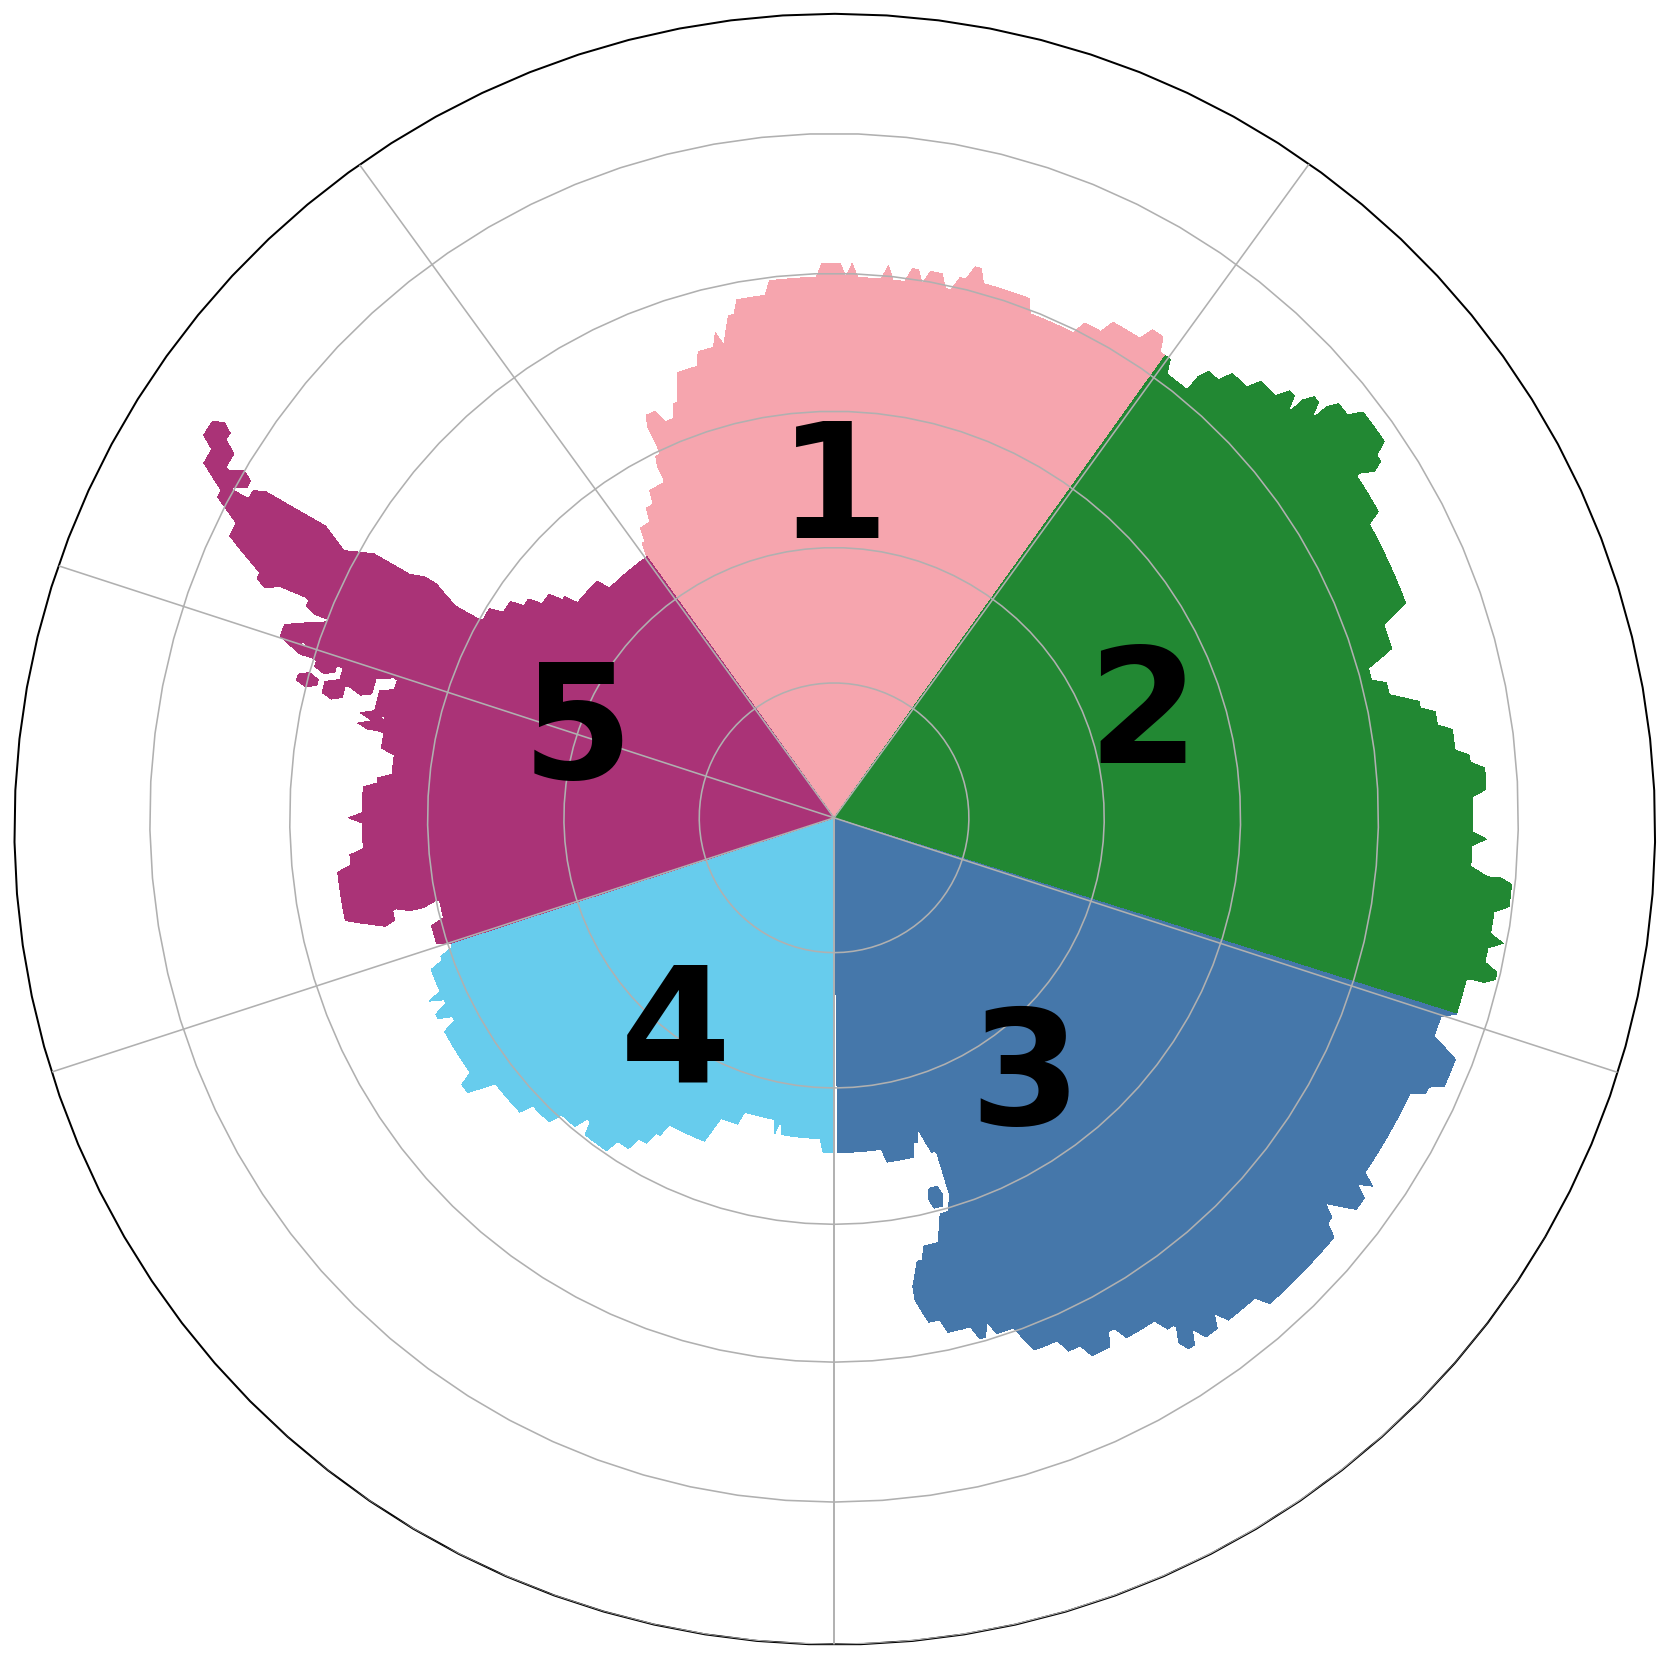

In [15]:
fig, ax=plt.subplots(ncols=1,nrows=1,figsize=(15,15),subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})
# plt.suptitle('Annual AR Frequency', size = 30)
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
grid=ax.gridlines(zorder = 20)
grid.n_steps=90
# grid.xlocator = mticker.FixedLocator([0,36, 72, 108, 144, 180, -180, -144, -108, -72, -36])
grid.xlocator = mticker.FixedLocator([36, 108,  180, -180,  -108, -72, -36, 36])
grid.ylocator = mticker.FixedLocator([ -90,-85,-80,-75,-70, -65,-60, -55, -50, -45, -40]) #-90, -85, -80, -75, -70, -65,
# ax.add_feature(ice_shelf_line, linewidth = 1,zorder = 11, color = 'black')
# ax.coastlines(resolution='50m', linewidth = 1,zorder = 11, color = 'black')

basins = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/AIS_basins_Zwally_MERRA2grid.nc').sel(lat = slice(-90,-60)).load()
basins = basins.Zwallybasins > 0
slice_start_extend = np.array([-36.5, 35.5, 107.5, -180.5 , -108.5])
slice_end_extend = np.array([36.5,1078.5, 180.5, -107.5 , -35.5])

for r in range(5):
    color = colors[r]
#     bins = np.arange(slice_start[r], slice_end[r]+6, 6)
#     bins = np.arange(slice_start[r], slice_end[r]+12, 12)
#     for b in range(len(regional_num_lons[r])):
#         rect = Rectangle(xy=(bins[b], -60), width=(bins[1]- bins[0])*.9, height = regional_num_lons[r][b], transform=ccrs.PlateCarree(), linestyle='-', color = color, lw=.9,  alpha = 1, zorder =20) 
#         ax.add_artist(rect)
   

    slice_data = basins.sel(lon  = slice(slice_start_extend[r], slice_end_extend[r]+.25))
    ax.contourf(slice_data.lon, slice_data.lat, xr.where(slice_data.values==True,1,0), levels = np.arange(-.5,1.5,.75),cmap = ListedColormap([ 'None', colors[r]]), transform=ccrs.PlateCarree())

# ax.text(-36,-40.5, '120', fontsize = 20, rotation = 30, ha='center',va='center',transform = ccrs.PlateCarree(), zorder = 30)
# ax.text(-36,-50, '60', fontsize = 20, rotation = 30, ha='center',va='center',transform = ccrs.PlateCarree(), zorder = 30)
# ax.text(-36,-60, '0', fontsize = 20, rotation = 30,ha='center',va='center',transform = ccrs.PlateCarree(), zorder = 30)

# ax.text(-180,-40, '120', fontsize = 20, rotation = 0, ha='center',va='center',transform = ccrs.PlateCarree(), zorder = 30)
# ax.text(-180,-50, '60', fontsize = 20, rotation = 0, ha='center',va='center',transform = ccrs.PlateCarree(), zorder = 30)
# ax.text(-180,-60, '0', fontsize = 20, rotation = 0,ha='center',va='center',transform = ccrs.PlateCarree(), zorder = 30)

ax.text(0,-78, '1', transform=ccrs.PlateCarree(), fontsize = 80, va = 'center', ha = 'center', zorder = 25, weight="bold")
ax.text(72,-78, '2', transform=ccrs.PlateCarree(), fontsize = 80, va = 'center', ha = 'center', zorder = 25, weight="bold")
ax.text(144,-78, '3', transform=ccrs.PlateCarree(), fontsize = 80, va = 'center', ha = 'center', zorder = 20, weight="bold")
ax.text(-144,-80, '4', transform=ccrs.PlateCarree(), fontsize = 80, va = 'center', ha = 'center', zorder = 20, weight="bold")
ax.text(-72,-80, '5', transform=ccrs.PlateCarree(), fontsize = 80, va = 'center', ha = 'center', zorder = 20, weight="bold")

plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/Regions.png', dpi = 300, transparent = True, bbox_inches = 'tight')

